In [140]:
#START: take query
# CONDITION: check sentiment

# A: negative
    # run diagnosis
    # respond

# B: positive
    # respond

#END

In [141]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

In [142]:
load_dotenv()

llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation"
)
model = ChatHuggingFace(llm=llm)

In [143]:
class SentimentSchema(BaseModel):
    sentiment: Literal["Positive", "Negative"] = Field(description="Sentiment of the review")

class DiagnosisSchema(BaseModel):
    tone: Literal["angry", "calm", "disappointed"] = Field(description="Tone of the review")
    issue: str = Field(description="The category of issue being faced")

In [144]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

sentiment_parser = JsonOutputParser(pydantic_object=SentimentSchema)
diagnosis_parser = JsonOutputParser(pydantic_object=DiagnosisSchema)

structured_sentiment = sentiment_parser.get_format_instructions()
structured_diagnosis = diagnosis_parser.get_format_instructions()

In [145]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["Positive", "Negative"]
    response: str
    diagnosis: dict

In [146]:
def checkReview(state: ReviewState) -> dict:
    
    prompt = PromptTemplate(
        template="Check the sentiment of this review.\n{format_instructions}\nReview: {review}",
        input_variables=["review"],
        partial_variables={"format_instructions": structured_sentiment},
    )
    
    chain = prompt | model | sentiment_parser
    
    answer = chain.invoke({"review": state['review']})
    return {'sentiment': answer['sentiment']}

# =====================Router==================================
def classifyReview(state: ReviewState) -> str:
    if state["sentiment"] == "Positive":
        return "Positive_Review"
    else:
        return "runDiagnosis"
# ============================================================


def Positive_Review(state: ReviewState) -> dict:
        answer = model.invoke(f"Write a thank you message for this review: {state['review']}").content
        
        return {'response': answer}

def runDiagnosis(state: ReviewState) -> dict:
    prompt = PromptTemplate(
         template="Analyze this review: {review}, tell the following things about this review: tone of the message, issue faced {review}  \n{format_instructions}",
         input_variables=["review"],
         partial_variables={"format_instructions": structured_diagnosis},
    )
    
    chain  = prompt | model | diagnosis_parser

    answer =  chain.invoke({"review": state['review']})
    return {'diagnosis':answer }

def Negative_Review(state: ReviewState) ->dict:
    
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue']}' issue and sounded '{diagnosis['tone']}',
    Write an empathetic, helpful resolution message.
    """
    response = model.invoke(prompt).content

    return {'response': response}

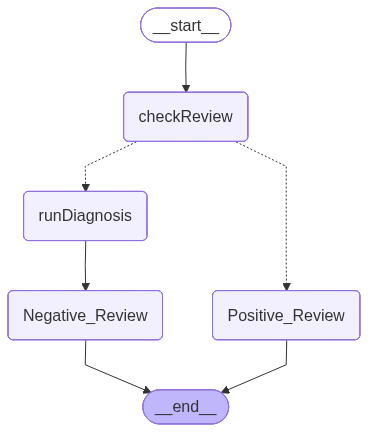

In [147]:
graph = StateGraph(ReviewState)

graph.add_node("checkReview", checkReview)
graph.add_node("Positive_Review", Positive_Review)
graph.add_node("runDiagnosis", runDiagnosis)
graph.add_node("Negative_Review", Negative_Review)

graph.add_edge(START, "checkReview")

graph.add_conditional_edges("checkReview", classifyReview,{
        "Positive_Review": "Positive_Review", 
        "runDiagnosis": "runDiagnosis"
    })

graph.add_edge("Positive_Review", END)
graph.add_edge("runDiagnosis", "Negative_Review")
graph.add_edge("Negative_Review", END)

workflow = graph.compile()

workflow

In [148]:
# query = "This is a bad phone, my UI got fucking fucked when the battery hit 10%"
query = "I'm gonna burn you all"
# query = "The phone is good, thats all I have to say"

test = workflow.invoke({'review': query})

print(test["response"])

Dear valued customer,

I am so sorry to hear that you're experiencing issues with our product/service. I can only imagine how frustrating this must be for you, and I want to assure you that we take all concerns seriously. Your satisfaction is our top priority, and I'm here to help you find a resolution.

Before we proceed, I'd like to offer my apologies for any inconvenience this has caused. I want to assure you that we're committed to providing the highest quality products and services, and it's clear that we've fallen short in your case.

To better understand the issue and assist you, could you please provide me with more details about what's not meeting your expectations? For example, what specifically is not working as it should, and what have you tried so far to resolve the issue?

In the meantime, I'd like to offer you a few options to address the issue:

1. Replacement or refund: If our product or service is not meeting your expectations, I'd be happy to discuss a replacement or

In [149]:
if "diagnosis" in test:
    print(test["diagnosis"].get("tone"))
else:
    print("No diagnosis performed (Positive review)")

angry
